# Packages

In [1]:
import numpy as np
import tensorflow as tf
import scipy

# Input informations

In [2]:
import numpy as np

def Input_Info():
    """
    ====================================================================================================================

    This function is to load the problem information, including:
        1. Define the problem geometry;
        2. Define the material property;
        3. Define the boundary condition;
        4. Define the FNN settings.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [ns]        [int]                   : Total number of sample points;
    [dx]        [float]                 : Sample points interval;
    [xy]        [Array of float32]      : Coordinates of all the sample points;
    [xy_r]      [Array of float32]      : Coordinates of the sample points on the right tip of the rod;
    [x_train]   [List]                  : PINN input list, contains all the coordinates information;
    [s_r_x]     [Array of float32]      : Traction boundary condition on the right tip of the rod;
    [y_train]   [List]                  : PINN boundary condition list, contains the traction boundary condition;
    [n_input]   [int]                   : Number of inputs for the FNN;
    [n_output]  [int]                   : Number of outputs for the FNN;
    [layers]    [list]                  : Size of the FNN;
    [acti_fun]  [str]                   : The activation function used after each layer;
                                                        Available options:
                                                        'tanh'
                                                        'sigmoid'
                                                        'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
    [k_init]    [str]                   : The kernel initialisation method.
    [NN_info]   [list]                  : Neural Network information list, contains the settings for the FNN;
    [E]         [float]                 : Young's module.
        
    ====================================================================================================================
    """
    
    ### Define the number of sample points
    ns = 51
    
    ### Define the sample points' interval
    dx = 1./(ns-1)
    
    ### Initialize sample points' coordinates
    xy = np.zeros((ns, 1)).astype(np.float32)
    for i in range(0, ns):
        xy[i, 0] = i * dx
    xy_r = np.array([1.])
    
    ### Create the PINN input list
    x_train = [xy, xy_r]
    
    ### Define the Young's modulus
    E = 10.
    
    ### Define the traction boundary condition at the right tip of the rod
    s_r_x = 1.
    
    ### Create the PINN boundary condition list
    y_train = [s_r_x]
    # print(x_train ,y_train)
    
    ### Define the FNN settings
    n_input = 1
    n_output = 1
    layer = [np.array([5, 5, 5])]
    acti_fun = 'tanh'
    k_init = 'LecunNormal'
    NN_info = [n_input, n_output, layer, acti_fun, k_init]

    ### Visualise the summary of the problem setup
    print('*************************************************')
    print('Problem Info.')
    print('*************************************************\n')
    print(ns, 'sample points')
    print('The Young''s module is', E,'.\n')
    print('*************************************************')
    print('Neural Network Info.')
    print('*************************************************\n')
    print('net_u \nNumber of input:',n_input,', Number of output:',n_output,'.')
    print(len(layer[0]),'hidden layers,',layer[0][0],' neurons per layer.\n')
    print('*************************************************\n')

    return ns, x_train, y_train, E, dx, NN_info
# Input_Info()

# FNN

In [3]:
def FNN(n_input, n_output, layers, acti_fun='tanh', k_init='LecunNormal'):
    """
    ====================================================================================================================

    This function is to initialise a FNN.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [n_input]   [int]                   : Number of inputs for the FNN;
    [n_output]  [int]                   : Number of outputs for the FNN;
    [layers]    [list]                  : Size of the FNN;
    [acti_fun]  [str]                   : The activation function used after each layer;
                                                        Available options:
                                                        'tanh'
                                                        'sigmoid'
                                                        'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
    [k_init]    [str]                   : The kernel initialisation method;
    [x]         [Keras layer]           : Input of the FNN;
    [temp]      [Keras layer]           : Hidden layers of the FNN;
    [y]         [Keras layer]           : Output of the FNN;
    [net]       [Keras model]           : The built FNN.

    ====================================================================================================================
    """

    ### Setup the input layer of the FNN
    x = tf.keras.layers.Input(shape=(n_input))
    
    ### Setup the hidden layers of the FNN
    temp = x
    for l in layers:
        temp = tf.keras.layers.Dense(l, activation = acti_fun, kernel_initializer=k_init)(temp)
    
    ### Setup the output layers of the FNN
    y = tf.keras.layers.Dense(n_output, kernel_initializer=k_init)(temp)

    ### Combine the input, hidden, and output layers to build up a FNN
    net = tf.keras.models.Model(inputs=x, outputs=y)

    return net


# PINN
## Finding the physics informed loss function which is requires derivatives

In [4]:

class Dif(tf.keras.layers.Layer):
    """
    ====================================================================================================================

    This is the class for calculating the differential terms of the FNN's output with respect to the FNN's input. We
    adopt the GradientTape function provided by the TensorFlow library to do the automatic differentiation.
    This class include 2 functions, including:
        1. __init__()         : Initialise the parameters for differential operator;
        2. call()             : Calculate the differential terms.

    ====================================================================================================================
    """

    def __init__(self, fnn, **kwargs):
        """
        ================================================================================================================

        This function is to initialise for differential operator.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [fnn]       [Keras model]           : The Feedforward Neural Network.
        
        ================================================================================================================
        """
        self.fnn = fnn
        super().__init__(**kwargs)

    def call(self, x):
        """
        ================================================================================================================

        This function is to calculate the differential terms.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [x]         [Keras model]           : The coordinate array;
        [temp]      [Keras tensor]          : The intermediate output from the FNN;
        [u]         [Keras tensor]          : The displacement predictions;
        [u_x]       [Keras tensor]          : The first-order derivative of the u with respect to the x;
        [u_xx]      [Keras tensor]          : The second-order derivative of the u with respect to the x.

        ================================================================================================================
        """

        ### Apply the GradientTape function
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)

                ### Obtain the intermediate output from the FNN
                temp = self.fnn(x)

                ### Calculate the displacement output by times the coordinate to naturally satisfy the displacement
                ### boundary condition
                u = temp * x

            ### Obtain the first-order derivative of the output with respect to the input
            u_x = g.gradient(u, x)
            del g

        ### Obtain the second-order derivative of the output with respect to the input
        u_xx = gg.gradient(u_x, x)
        del gg

        return u_x, u_xx


In [5]:
def Material(U_x, U_xx, E):

    ### Calculate strain
    epsilon = U_x

    ### Calculate stress
    sigma = E * epsilon

    ### Calculate the residual from equilibrium equation
    Ge = E * U_xx

    return epsilon, sigma, Ge

In [6]:

def PINN(net_u, E):
    """
    ====================================================================================================================

    This function is to initialize a PINN.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [net_u]     [keras model]           : The trained FNN for displacement u;
    [xy]        [Keras input layer]     : Coordinates of all the sample points;
    [xy_r]      [Keras input layer]     : Coordinate of the sample point at the right tip of the rod;
    [U_r]       [Keras tensor]          : Displacement at the right tip of the rod;
    [U_x]       [Keras tensor]          : First-order derivative of displacement with respect to x direction;
    [U_xx]      [Keras tensor]          : Second-order derivative of displacement with respect to x direction;
    [U_r_x]     [Keras tensor]          : First-order derivative of displacement at the right tip of the rod with
                                          respect to x direction;
    [U_r_xx]    [Keras tensor]          : Second-order derivative of displacement at the right tip of the rod with
                                          respect to x direction;
    [epsilon]   [Keras tensor]          : Strain;
    [sigma]     [Keras tensor]          : Stress;
    [Ge]        [Keras tensor]          : Residual from the equilibrium equation;
    [sigma_r]   [Keras tensor]          : Stress at the right tip of the rod;
    [E]         [float]                 : Young's module.

    ====================================================================================================================
    """

    ### declare PINN's inputs
    xy = tf.keras.layers.Input(shape=(1,))
    xy_r = tf.keras.layers.Input(shape=(1,))
    
    ### initialize the differential operators
    Dif_u = Dif(net_u)
    
    ### obtain the displacment at the right tip of the rod
    u_r = net_u(xy_r) * xy_r
    ##fet weight of fnn
    # print('weight of fnn',len(net_u.get_weights()))
    ### obtain partial derivatives of u with respect to x
    u_x, u_xx = Dif_u(xy)
    u_r_x, u_r_xx = Dif_u(xy_r)
       
    ### obtain the residuals from the governing equation and traction boundary condition
    epsilon, sigma, Ge = Material(u_x, u_xx, E)
    _, sigma_r, _ = Material(u_r_x, u_r_xx, E)
    
    ### build up the PINN
    pinn = tf.keras.models.Model(inputs=[xy, xy_r], outputs=[Ge, sigma_r, sigma, epsilon, u_r])
        
    return pinn

# Losses

In [7]:
def Collocation_Loss(y_p, y):
    """
    ====================================================================================================================

    Collocation loss function

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [y_p]       [list]                  : Outputs from the PINN;
    [y]         [list]                  : The ground truth data;
    [l1]        [Keras tensor]          : The loss term from the equilibrium equation;
    [l2]        [Keras tensor]          : The loss term from the traction boundary condition;
    [loss]      [Keras tensor]          : The final loss

    ====================================================================================================================
    """

    ### Residual from the governing equation
    l1 = tf.reduce_mean(tf.square(y_p[0]))

    ### Residual from the traction boundary condition
    l2 = tf.reduce_mean(tf.square(y_p[1]-y[0]))

    ### Final loss
    loss = l1 + l2

    return loss, l1, l2

In [8]:
def Energy_Loss(y_p, y, dx):
    """
    ====================================================================================================================

    Energy-based loss function

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [y_p]       [list]                  : Outputs from the PINN;
    [y]         [list]                  : The ground truth data;
    [dx]        [float]                 : Sample points interval;
    [l1]        [Keras tensor]          : The internal potential energy;
    [l2]        [Keras tensor]          : The potential energy of the external traction force;
    [loss]      [Keras tensor]          : The final loss

    ====================================================================================================================
    """

    ### Internal potential energy
    l1 = 0.5 * dx * tf.reduce_sum(y_p[2] * y_p[3])
    ### Potential energy of the external force
    l2 = tf.reduce_sum(y_p[4] * y[0])
    ### Final Loss
    loss = l1 - l2

    return loss, l1, l2

# Optimizer

In [9]:
import scipy.optimize

class L_BFGS_B:
    """
    ====================================================================================================================

    This is the class for the L-BFGS-B optimiser. We adopt core algorithm of the L-BFGS-B algorithm is provided by the
    Scipy library. This class include 5 functions, including:
        1. __init__()         : Initialise the parameters for the L-BFGS-B optimiser;
        2. pi_loss()          : Calculate the physics-informed loss;
        3. loss_grad()        : Obtain the gradients of the physics-informed loss with respect to the weighs and biases;
        4. set_weights()      : Set the modified weights and biases back to the neural network structure;
        5. fit()              : Execute training process.

    ====================================================================================================================
    """

    def __init__(self, pinn, x_train, y_train, dx, factr=10, pgtol=1e-10, m=50, maxls=50, maxfun=10000):
        """
        ================================================================================================================

        This function is to initialise the parameters used in the L-BFGS-B optimiser.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [dx]        [float]                 : Sample points interval;
        [factr]     [int]                   : The optimiser option. Please refer to SciPy;
        [pgtol]     [float]                 : The optimiser option. Please refer to SciPy;
        [m]         [int]                   : The optimiser option. Please refer to SciPy;
        [maxls]     [int]                   : The optimiser option. Please refer to SciPy;
        [maxfun]    [int]                   : Maximum number of iterations for training;
        [iter]      [int]                   : Number of training iterations;
        [his_l1]    [list of float32]       : History values of the l1 loss term;
        [his_l2]    [list of float32]       : History values of the l1 loss term.

        ================================================================================================================
        """

        ### Initialise the parameters
        self.pinn = pinn
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.dx = dx
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxfun = maxfun
        self.iter = 0
        self.his_l1 = []
        self.his_l2 = []

    def pi_loss(self, weights):
        """
        ================================================================================================================

        This function is to calculate the physics-informed loss.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [weights]   [list]                  : The weights and biases;
        [pinn]      [Keras tensor]          : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [loss]      [Keras tensor]          : Current value of the physics-informed loss;
        [l1]        [Keras tensor]          : The l1 loss term;
        [l2]        [Keras tensor]          : The l2 loss term;
        [grads]     [Keras tensor]          : The gradients of the physics-informed loss with respect to weights and
                                              biases;
        [iter]      [int]                   : Number of training iterations.

        ================================================================================================================
        """

        ### Update the weights and biases to the FNN
        self.set_weights(weights)

        ### Calculate the physics-informed loss and its gradients with respect to weights and biases
        loss, grads, l1, l2 = self.loss_grad(self.x_train, self.y_train)

        ### Count number of the training iteration
        self.iter = self.iter + 1

        ### Print the loss terms every 10 training iterations
        if self.iter % 10 == 0:
            print('Iter: %d   L1 = %.4g   L2 = %.4g' % (self.iter, l1.numpy(), l2.numpy()))

        ### Convert loss and grads from Keras tensor to ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')

        ### Save the current loss term in different np.array
        self.his_l1.append(l1)
        self.his_l2.append(l2)

        return loss, grads

    @tf.function
    def loss_grad(self, x_train, y_train):
        """
        ================================================================================================================

        This function is to obtain the gradients of the physics-informed loss with respect to the weighs and biases.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [y_p]       [list]                  : List of predictions from the PINN;
        [loss]      [Keras tensor]          : Current value of the physics-informed loss;
        [l1]        [Keras tensor]          : The l1 loss term;
        [l2]        [Keras tensor]          : The l2 loss term;
        [dx]        [float]                 : Sample points interval;
        [grads]     [Keras tensor]          : The gradients of the physics-informed loss with respect to weights and
                                              biases.

        ================================================================================================================
        """

        with tf.GradientTape() as g:

            ### Predict outputs from the current PINN
            y_p = self.pinn(x_train)

            ### Apply the collocation loss function
            loss, l1, l2 = Collocation_Loss(y_p, y_train)

            ### Apply the energy-based loss function
            # loss, l1, l2 = Energy_Loss(y_p, y_train, self.dx)

        ### Obtain the gradients through automatic differentiation
        ### (GradientTape function provided by the TensorFlow)
        grads = g.gradient(loss, self.pinn.trainable_variables)
        print('trainable variables',len(self.pinn.trainable_variables),self.pinn.trainable_variables)
        return loss, grads, l1, l2

    def set_weights(self, weights):
        """
        ================================================================================================================

        This function is to Set the modified weights and biases back to the neural network structure.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [keras model]           : The Physics-informed neural network;
        [shapes]    [list]                  : The shapes of neural network's weights and biases;
        [weights]   [list]                  : The weights and biases.

        ================================================================================================================
        """

        ### Obtain the shapes of neural network's weights and biases
        shapes = [w.shape for w in self.pinn.get_weights()]
        print('weights of pinn',len(self.pinn.get_weights()))
        ### Compute splitting indices
        split_ids = np.cumsum([np.prod(shape) for shape in [0] + shapes])

        ### Reshape the modified weights and biases to fit the neural network structure
        weights = [weights[from_id:to_id].reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]

        ### Set weights and biases to the neural network
        self.pinn.set_weights(weights)

        return None

    def fit(self):
        """
        ================================================================================================================

        This function is to execute training process.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [ini_w]     [ndarray]               : The initial weights and biases;
        [pi_loss]   [function]              : The function that calculates the physics-informed loss (line 61);
        [factr]     [int]                   : The optimiser option. Please refer to SciPy;
        [pgtol]     [float]                 : The optimiser option. Please refer to SciPy;
        [m]         [int]                   : The optimiser option. Please refer to SciPy;
        [maxls]     [int]                   : The optimiser option. Please refer to SciPy;
        [maxfun]    [int]                   : Maximum number of iterations for training;
        [result]    [tuple]                 : The result returned by the optimiser;
        [his_l1]    [list of float32]       : History values of the l1 loss term;
        [his_l2]    [list of float32]       : History values of the l2 loss term.

        ================================================================================================================
        """

        ### Get initial weights and biases
        ini_w = np.concatenate([ w.flatten() for w in self.pinn.get_weights() ])

        ### Optimise the weights and biases via the L-BFGS-B optimiser
        print('Optimizer: L-BFGS-B (Provided by Scipy package)')
        print('Initializing ...\n')
        result = scipy.optimize.fmin_l_bfgs_b(func=self.pi_loss, x0=ini_w,
            factr=self.factr, pgtol=self.pgtol, m=self.m, maxls=self.maxls, maxfun=self.maxfun)

        return result, [np.array(self.his_l1), np.array(self.his_l2)]


# Preprocessing the all above information for training

In [10]:

import numpy as np
def Pre_Process():
    """
    ====================================================================================================================

    Pre_Process function is to:
        1. Load the problem information;
        2. Build up the FNN;
        3. Build up the PINN;
        4. Initialize the L-BFGS-B optimiser.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [ns]        [int]                   : Total number of sample points;
    [ns_u]      [int]                   : Number of sample points on top boundary of the beam;
    [ns_l]      [int]                   : Number of sample points on left boundary of the beam;
    [dx]        [float]                 : Sample points interval;
    [x_train]   [List]                  : PINN input list, contains all the coordinates information;
    [y_train]   [List]                  : PINN boundary condition list, contains all the traction boundary conditions;
    [NN_info]   [list]                  : Neural Network information list, contains the settings for the FNN;
    [E]         [float]                 : Young's module;
    [net_u]     [Keras model]           : The built FNN;
    [pinn]      [Keras model]           : The built PINN;
    [l_bfgs_b]  [class]                 : The initialised L-BFGS-B optimiser.
        
    ====================================================================================================================
    """
    
    ### Input information
    ns, x_train, y_train, E, dx, NN_info = Input_Info()
    print('x_train_shape',np.array(x_train).shape,x_train,'y_train_Shape',np.array(y_train).shape,y_train)
    ### Initialize the Feedforward Neural Networks
    net_u = FNN(n_input=NN_info[0], n_output=NN_info[1], layers=NN_info[2][0], acti_fun=NN_info[3], k_init=NN_info[4])
    
    ### Initialize the Physics-informed Neural Network
    pinn = PINN(net_u, E)
    
    ### Initialize the L-BFGS-B optimizer
    l_bfgs_b = L_BFGS_B(pinn, x_train, y_train, dx)

    return net_u, pinn, l_bfgs_b

# Training

In [11]:
import time

def Train(l_bfgs_b):
    """
    ====================================================================================================================

    Train function is to train the neural networks with the selected optimizer.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [result]    [tuple]                 : The result returned by the optimiser;
    [his_loss]  [list]                  : History values of the loss terms;
    [t]         [float]                 : CPU time used for training;
    [l]         [float]                 : Final loss;
    [it]        [int]                   : The number of iterations for convergence.

    ====================================================================================================================
    """

    ### Execute the training process
    time_start = time.time()
    result, his_loss = l_bfgs_b.fit()
    time_end = time.time()

    ### Record the training time
    t = time_end-time_start

    ### Record the final loss
    l = result[1]

    ### Record the number of iterations for convergence
    it = result[2]['funcalls']

    print('\n*************************************************\n')
    print('Time cost is', t, 's')
    print('Final loss is', l, '')
    print('Training converges by', it, 'iterations\n')
    print('*************************************************\n')
    
    return t, l, it, his_loss

# Post processing 

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

def Post_Process(net_u, pinn, his_loss):
    """
    ====================================================================================================================

    Post_Process function is to:
        1. Visualize the displacement, strain, and stress;
        2. Output results.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.
    
    [xy]        [array of float]        : Coordinates of all the sample points;
    [u]         [array of float]        : Displacement;
    [sigma]     [array of float]        : Stress;
    [epsilon]   [array of float]        : Strain;
    [net_u]     [keras model]           : The trained FNN for displacement u;
    [pinn]      [Keras model]           : The Physics-Informed Neural Network;
    [his_loss]  [list]                  : History values of the loss terms.

    ====================================================================================================================
    """

    plt.rcParams.update({'font.size': 9})
    
    xy = np.zeros((51, 1)).astype(np.float32)
    k = 0
    for i in range(0,51):
            xy[i, 0] = i * 1/50
    
    u = net_u.predict(xy) * xy
    temp = pinn.predict([xy for i in range(0,2)])
    sigma = temp[1]
    epsilon = temp[3]
    
    # plot figure for displacement u
    fig1 = plt.figure(1, figsize=(6,6))
    plt.plot(np.array([0,1]),np.array([0,0.1]), color = '#0072BD',zorder = 1)
    plt.scatter(xy, u, s=10, c='#D95319',zorder = 2)
    plt.xlabel('$\it{x}$ (m)', fontdict = {'fontname': 'Calibri'})
    plt.ylabel('$\it{U}$ (m)', fontdict = {'fontname': 'Calibri'})
    # plt.title('Displacment', fontdict = {'fontname': 'Calibri'})
    plt.legend(['Analytic', 'PINN'])
    # plt.axis('equal')
    plt.xlim([0, 1])
    plt.ylim([0, 0.1])
    plt.savefig('u.pdf', dpi = 600, bbox_inches = 'tight')
    plt.show()
    
    # plot figure for strain epsilon
    fig2 = plt.figure(2, figsize=(6,6))
    plt.plot(np.array([0,1]),np.array([0.1,0.1]), color = '#0072BD',zorder = 1)
    plt.scatter(xy, epsilon, s = 10, c = '#D95319',zorder = 2)
    plt.xlabel('$\it{x}$ (m)', fontdict = {'fontname': 'Calibri'})
    plt.ylabel('$\it{\epsilon}$', fontdict = {'fontname': 'Calibri'})
    # plt.title('Strain', fontdict = {'fontname': 'Calibri'})
    plt.legend(['Analytic', 'PINN'])
    # plt.axis('equal')
    plt.xlim([0, 1])
    plt.ylim([0.05, .15])
    plt.savefig('epsilon.pdf', dpi = 600, bbox_inches = 'tight')
    plt.show()
    
    # plot figure for stress sigma
    fig3 = plt.figure(3, figsize=(6,6))
    plt.plot(np.array([0,1]),np.array([1,1]), color = '#0072BD',zorder = 1)
    plt.scatter(xy, sigma, s = 10, c = '#D95319',zorder = 2)
    plt.xlabel('$\it{x}$ (m)', fontdict = {'fontname': 'Calibri'})
    plt.ylabel('$\it{\sigma}$ $(N/m^2)$', fontdict = {'fontname': 'Calibri'})
    # plt.title('Stress', fontdict = {'fontname': 'Calibri'})
    plt.legend(['Analytic', 'PINN'])
    plt.axis('equal')
    plt.xlim([0, 1])
    plt.ylim([0.5, 1.5])
    plt.savefig('sigma.pdf', dpi = 600, bbox_inches = 'tight')
    plt.show()
    
    # plot figure for hist_loss
    fig4 = plt.figure(4, figsize=(8,3))
    plt.plot(his_loss[0], color = 'r',zorder = 2,linestyle = '--')
    plt.plot(his_loss[1], color = 'b',zorder = 3,linestyle = '--')
    plt.plot(his_loss[0] + his_loss[1], color = 'k',zorder = 1)
    plt.yscale('log')
    plt.xlabel('Iteration', fontdict = {'fontname': 'Calibri'})
    plt.ylabel('Loss', fontdict = {'fontname': 'Calibri'})
    plt.title('Loss History', fontdict = {'fontname': 'Calibri'})
    plt.legend(['$L_{ge}$', '$L_{bc}$', '$L$'])
    plt.savefig('hist_loss.pdf', dpi = 600, bbox_inches = 'tight')
    plt.show()
    
    # output data in the 'out.mat' file
    scipy.io.savemat('out.mat', {'xy': xy, 'u': u, 'sigma': sigma, 'epsilon': epsilon})
    
    return None

# Main function call

*************************************************
Problem Info.
*************************************************

51 sample points
The Youngs module is 10.0 .

*************************************************
Neural Network Info.
*************************************************

net_u 
Number of input: 1 , Number of output: 1 .
3 hidden layers, 5  neurons per layer.

*************************************************

x_train_shape (2,) [array([[0.  ],
       [0.02],
       [0.04],
       [0.06],
       [0.08],
       [0.1 ],
       [0.12],
       [0.14],
       [0.16],
       [0.18],
       [0.2 ],
       [0.22],
       [0.24],
       [0.26],
       [0.28],
       [0.3 ],
       [0.32],
       [0.34],
       [0.36],
       [0.38],
       [0.4 ],
       [0.42],
       [0.44],
       [0.46],
       [0.48],
       [0.5 ],
       [0.52],
       [0.54],
       [0.56],
       [0.58],
       [0.6 ],
       [0.62],
       [0.64],
       [0.66],
       [0.68],
       [0.7 ],
       [0.72],
 

C:\Users\pk235\AppData\Local\Temp\ipykernel_6596\171255717.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print('x_train_shape',np.array(x_train).shape,x_train,'y_train_Shape',np.array(y_train).shape,y_train)


Optimizer: L-BFGS-B (Provided by Scipy package)
Initializing ...

weights of pinn 8
trainable variables 8 [<tf.Variable 'dense_16/kernel:0' shape=(1, 5) dtype=float32>, <tf.Variable 'dense_16/bias:0' shape=(5,) dtype=float32>, <tf.Variable 'dense_17/kernel:0' shape=(5, 5) dtype=float32>, <tf.Variable 'dense_17/bias:0' shape=(5,) dtype=float32>, <tf.Variable 'dense_18/kernel:0' shape=(5, 5) dtype=float32>, <tf.Variable 'dense_18/bias:0' shape=(5,) dtype=float32>, <tf.Variable 'dense_19/kernel:0' shape=(5, 1) dtype=float32>, <tf.Variable 'dense_19/bias:0' shape=(1,) dtype=float32>]
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
Iter: 10   L1 = 0.003451   L2 = 6.013e-08
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
weights of pinn 8
Iter: 20   L1 = 0.0003834   L

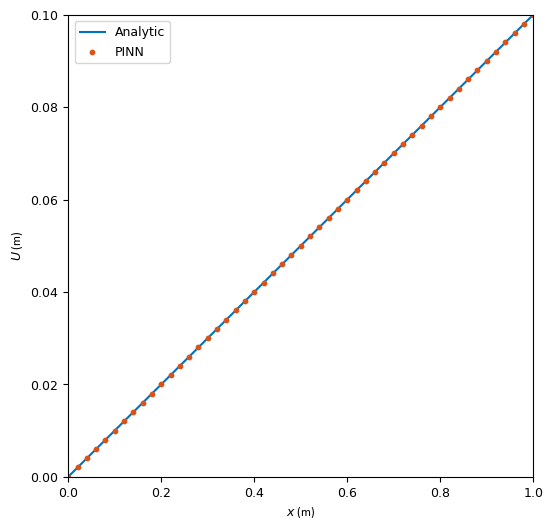

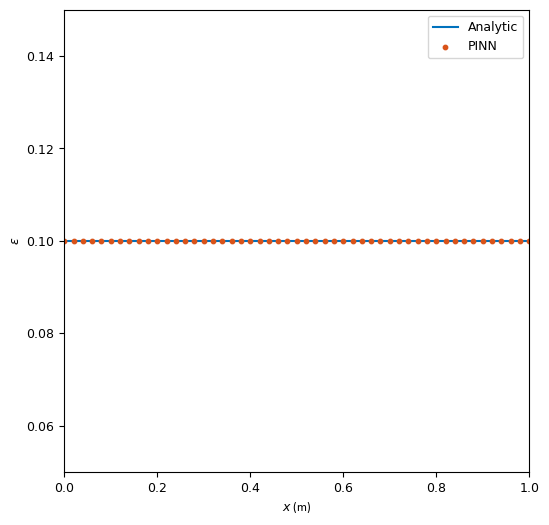

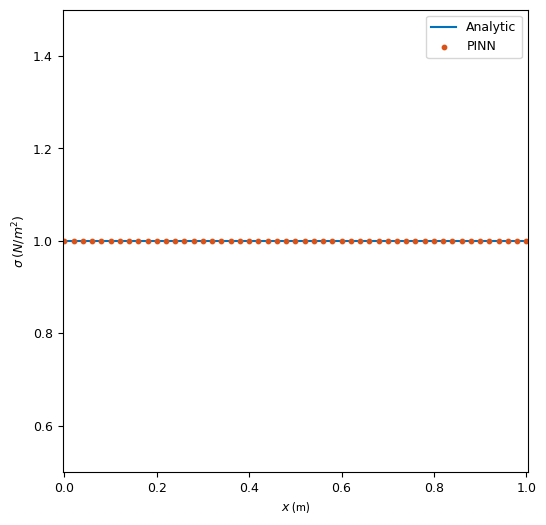

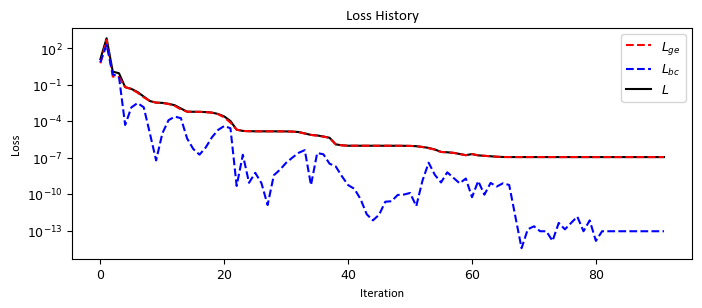

In [21]:

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

"""
========================================================================================================================

    This code is for the 1D stretching rod problem in "An introduction to programming physics-informed
    neural network-based computational solid mechanics". 
    DOI: https://doi.org/10.48550/arXiv.2210.09060
    
    A 1D stretching rod problem is modeled here. The length of the rod is L = 1 m. A stretching 
    force, F = 1 N/m2, is applied at the right end of the rod. 51 sample points are uniformly 
    generated in the computational domain with 0.02 m spacing. We use one FNN to predict the 
    displacement field u. The Young's module of this problem is E = 10 Pa.
    
    The code includes three parts:
        1. Pre-Processing part  : Initialize the geometry, material properties, boundary conditions,
                                  feedforward neural networks, physics-informed neural networks 
                                  and optimizer.
        2. Training part        : Train the neural networks with the selected optimizer.
        3. Post-Processing part : Visualize and output the results.

    Libraries used in this code are as follow:
        Name             Source                             Location
        'TensorFlow'     https://www.tensorflow.org/
        'NumPy'          https://numpy.org/
        'SciPy'          https://scipy.org/
        'Matplotlib'     https://matplotlib.org/
        'time'           In Python3
        'os'             In Python3
        'Pre_Process'    Self developed                     ./lib
        'Train'          Self developed                     ./lib
        'Post_Process'   Self developed                     ./lib
        'Input_Info'     Self developed                     ./lib/Pre/
        'FNN'            Self developed                     ./lib/Pre/
        'PINN'           Self developed                     ./lib/Pre/
        'L_BFGS_B'       Self developed                     ./lib/Pre/
        'Loss'           Self developed                     ./lib/Pre/
        
    This code is developed by @Jinshuai Bai and @Yuantong Gu. For more details, please contact: 
    jinshuai.bai@hdr.qut.edu.au
    yuantong.gu@qut.edu.au
    
========================================================================================================================
"""

if __name__ == '__main__':
    """
        Pre_Process() function is to:
            1. Define the geometry of the problem
            2. Define the material properties
            3. Define the boundary conditions
            4. Initialize the neural networks
            5. Initialize the optimiser
    """
    
    net_u, pinn, l_bfgs_b = Pre_Process()
    
    """
        Train() function is to train the PINN with the selected optimiser 
    """
    
    T, L, it, his_loss = Train(l_bfgs_b)
    
    """
        Post_Process() function is to:
            1. Visualize the predicted field variables
            2. Output results
    """
    
    Post_Process(net_u, pinn, his_loss)
    
